In [10]:
"""拟合圆，并检测小瑕疵"""

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import math
from PIL import Image

def dis(imgarray):
    """显示图片"""
    img = Image.fromarray(imgarray[:, :, ::-1].astype(np.uint8))
    display(img)

def circle_func(a, b, r, x):
    return np.sqrt(r ** 2 - (x - a) ** 2) + b, -np.sqrt(r ** 2 - (x - a) ** 2) + b


def get_xy(cnt):
    new_cnt = np.array(cnt)
    x = new_cnt[..., 0]
    x = x.flatten()
    y = new_cnt[..., 1]
    y = y.flatten()
    return x, y


class RANSAC:
    def __init__(self, x_data, y_data, n):
        self.x_data = x_data
        self.y_data = y_data
        self.n = n
        self.d_min = 99999
        self.vote_max = 0
        self.thres = 1.0
        self.best_model = None

    def random_sampling(self):
        sample = []
        save_ran = []
        count = 0

        # get three points from data
        while True:
            ran = np.random.randint(len(self.x_data))

            if ran not in save_ran:
                sample.append((self.x_data[ran], self.y_data[ran]))
                save_ran.append(ran)
                count += 1

                if count == 3:
                    break

        return sample

    def make_model(self, sample):
        # calculate A, B, C value from three points by using matrix

        pt1 = sample[0]
        pt2 = sample[1]
        pt3 = sample[2]

        A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
        B = np.array([[pt2[0] ** 2 - pt1[0] ** 2 + pt2[1] ** 2 - pt1[1] ** 2],
                      [pt3[0] ** 2 - pt2[0] ** 2 + pt3[1] ** 2 - pt2[1] ** 2]])

        inv_A = np.linalg.pinv(A)
        # inv_A = inv(A)

        c_x, c_y = np.dot(inv_A, B) / 2
        c_x, c_y = c_x[0], c_y[0]
        r = np.sqrt((c_x - pt1[0]) ** 2 + (c_y - pt1[1]) ** 2)

        return c_x, c_y, r

    def eval_model(self, model):
        d = 0
        c_x, c_y, r = model

        for i in range(len(self.x_data)):
            dis = np.sqrt((self.x_data[i] - c_x) ** 2 + (self.y_data[i] - c_y) ** 2)
            if abs(dis - r) < self.thres:
                d += 1

        '''
        for i in range(len(self.x_data)):
            dis = np.sqrt((self.x_data[i] - c_x) ** 2 + (self.y_data[i] - c_y) ** 2)

            if dis >= r:
                d += dis - r
            else:
                d += r - dis
        '''

        return d

    def execute_ransac(self):
        # find best model
        for i in range(self.n):
            model = self.make_model(self.random_sampling())
            d_temp = self.eval_model(model)

            if self.vote_max < d_temp:
                # print('model: ', model)
                self.best_model = model
                self.vote_max = d_temp

            '''
            if self.d_min > d_temp:
                self.best_model = model
                self.d_min = d_temp
            '''


def detection(cnts, center_of_circle, radius):
    """
    检测毛刺的函数
    输入原始轮廓，拟合圆心，拟合的半径
    """
    dist_list = []  # 两点之间距离
    path_list = []  # 毛刺点的位置信息
    for i in range(len(cnts)):
        x1 = cnts[i][0]  # 取出毛刺轮廓中的点
        x2 = np.array(center_of_circle)  # 圆心
        d = math.dist(x2, x1)  # 计算两点之间的欧式距离
        abs_d = abs(d - radius)  # 取绝对值
        if abs_d > 4:  # 阈值
            dist_list.append(abs_d)
            path_list.append(x1)

    # print('小毛刺位置信息：', path_list)
        # dist_list.append(d - radius)
    # print('单个位置信息', path_list[1][0])
    print('毛刺数量：', len(dist_list))
    # print(dist_list[:4])
    return path_list



def test_func(img_name,min_cnts):
    """
    图片名
    最小轮廓范围
    
    """
    
    img = cv2.imdecode(np.fromfile(os.path.join(img_name), dtype=np.uint8), -1)
    # dis(img)
    img1 = img.copy()
    # 给裁剪后的图形增加白色边框
    # img1 = cv2.copyMakeBorder(img1, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    img_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    # im_blur = cv2.GaussianBlur(img_gray, (5, 5), 5)
    ret, binary = cv2.threshold(img_gray, 190, 255, cv2.THRESH_BINARY_INV)  # 二值化

    cnts, hie = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    cnts_list = []
    big_cnts_list = []
    for i in range(len(cnts)):
        cir_len = cv2.arcLength(cnts[i], True)  # 过滤轮廓
        if min_cnts < cir_len:
            cnts_list.append(cnts[i])
            big_cnts_list.append(cir_len)
    
    print(big_cnts_list)
    print('轮廓个数：', len(cnts_list))
    
    for i in range(len(cnts_list)):
        tx, ty = get_xy(cnts_list[i])
        # len_cnts = cv2.arcLength(cnts_list[2], True)
        # print('c', len_cnts)
       
        ransac = RANSAC(tx, ty, 100)
        # execute ransac algorithm
        ransac.execute_ransac()

        # get best model from ransac
        a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]

        # show result
        cv2.circle(img1, (int(a), int(b)), int(r), (0, 255, 0), 2)
        print('圆心：', (int(a), int(b)), '半径：', r)
        # 检测小毛刺
        path_list = detection(cnts=cnts_list[i], center_of_circle=(int(a), int(b)), radius=r)
        for i in range(len(path_list)):
            cv2.circle(img1, (int(path_list[i][0]), int(path_list[i][1])), int(3), (0, 0, 255), 2)

    dis(img1)
    
    
    
    


[1142.413337111473, 1859.0377893447876]
轮廓个数： 2
圆心： (301, 299) 半径： 172.07710059009946
毛刺数量： 0
圆心： (300, 300) 半径： 277.74263316329
毛刺数量： 0


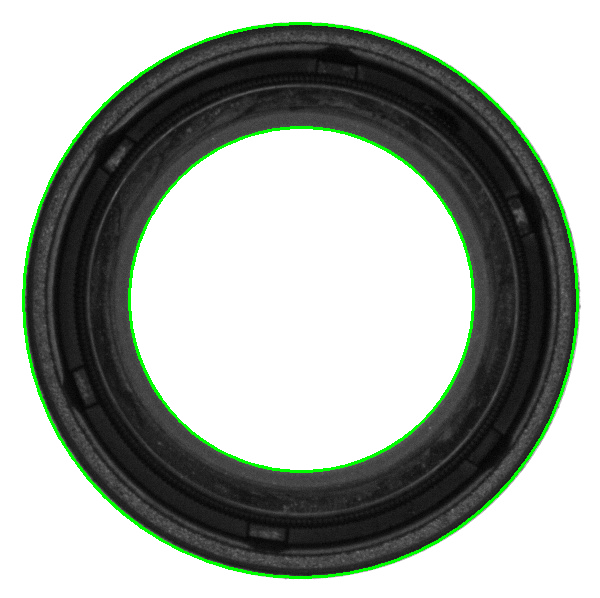

In [11]:
    
test_func(
    img_name= './20230131_173655.jpg',
    min_cnts=300,
)